In [1]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from matplotlib import rcParams
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits

from keras.layers import Dense, Flatten, Conv1D, Input, Lambda, MaxPool1D
from keras.layers import BatchNormalization, UpSampling1D, Flatten, Reshape
from keras import Model
from keras.optimizers import Adam
import keras.backend as K
import tensorflow_probability as tfp

sns.set(context='poster', style='whitegrid')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
WINDOW_SIZE = 20
NUM_FEATURES = 10

In [4]:
def make_synthetic_data(num_samples=10000, num_features=10, num_components=5):
    features = list()
    x = np.arange(num_samples)
    for i in range(num_features):
        amplitudes = np.random.randn(num_components)
        frequencies = np.random.randn(num_components)
        y = np.zeros(num_samples)
        for amplitude, frequency in zip(amplitudes, frequencies):
            func = np.random.choice([np.sin, np.cos])
            y += amplitude * func(0.2 * frequency * x)
        features.append(y)
    data = np.array(features)
    return data.T

In [5]:
def windowize(data, window_size=20, stride=1):
    num_samples = len(data)
    idx_range = [(idx, idx+window_size) for idx 
                 in range(0, num_samples-window_size+1, stride)]
    windows = list()
    for start_idx, end_idx in idx_range:
        window = data[start_idx:end_idx]
        windows.append(window)
    windows = np.array(windows)
    return windows

In [6]:
data = make_synthetic_data(num_features=NUM_FEATURES)
data_train = windowize(data, window_size=WINDOW_SIZE, stride=1)
data_infer = windowize(data, window_size=WINDOW_SIZE, stride=WINDOW_SIZE)

In [7]:
def make_model():
    K.clear_session()
    input_ = Input(shape=(20, 10))
    a = Conv1D(
        32, kernel_size=3, strides=2, padding='same',
        activation='relu')(input_)
    a = Conv1D(
        64, kernel_size=3, strides=2, padding='same',
        activation='relu')(a)
    a = Conv1D(
        126, kernel_size=3, strides=2, padding='same',
        activation='relu')(a)
    a = Conv1D(
        64, kernel_size=3, strides=1, padding='valid',
        activation='relu')(a)
    a = UpSampling1D(5)(a)
    a = Conv1D(
        64, kernel_size=3, strides=1, padding='valid',
        activation='relu')(a)
    a = UpSampling1D(4)(a)
    a = Conv1D(
        32, kernel_size=4, strides=2, padding='same',
        activation='relu')(a)
    a = UpSampling1D(4)(a)

    # Split for mean
    means = Conv1D(
        10, kernel_size=5, strides=1, padding='valid',
        activation='linear')(a)
    
    # Split for standard deviation
    stds = Conv1D(
        10, kernel_size=5, strides=1, padding='valid',
        activation='relu')(a)
    model = Model(inputs=input_, outputs=[means, stds])
    
    # Define custom loss function
    normal = tfp.distributions.Normal(means, stds + 1e-5) # Numerical stability
    log_probs = normal.log_prob(input_)
    loss = -tf.keras.backend.mean(log_probs)
    model.add_loss(loss)
    
    # Regularize standard deviation
#     std_l2 = tf.norm(stds, axis=1)
#     std_l2 = K.mean(std_l2)
#     model.add_loss(2 * std_l2)

    return model

In [8]:
model = make_model()

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
model.compile(optimizer=Adam(lr=0.00001))
model.fit(
    x=data_train, y=None, epochs=20, batch_size=256, shuffle=False,
    validation_split=0.1)

Train on 8982 samples, validate on 999 samples
Epoch 1/20
8982/8982 [==============================] - 3s 378us/step - loss: 0.9986 - val_loss: 1.0802
Epoch 2/20
8982/8982 [==============================] - 1s 111us/step - loss: 0.9981 - val_loss: 1.0797
Epoch 3/20
8982/8982 [==============================] - 1s 106us/step - loss: 0.9984 - val_loss: 1.0790
Epoch 4/20
8982/8982 [==============================] - 1s 111us/step - loss: 0.9982 - val_loss: 1.0805
Epoch 5/20
8982/8982 [==============================] - 1s 137us/step - loss: 0.9977 - val_loss: 1.0798
Epoch 6/20
8982/8982 [==============================] - 1s 118us/step - loss: 0.9975 - val_loss: 1.0795
Epoch 7/20
8982/8982 [==============================] - 1s 120us/step - loss: 0.9973 - val_loss: 1.0791
Epoch 8/20
8982/8982 [==============================] - 1s 115us/step - loss: 0.9971 - val_loss: 1.0796
Epoch 9/20
8982/8982 [==============================] - 1s 109us/step - loss: 0.9969 - val_loss: 1.0792
Epoch 10/20
8982/

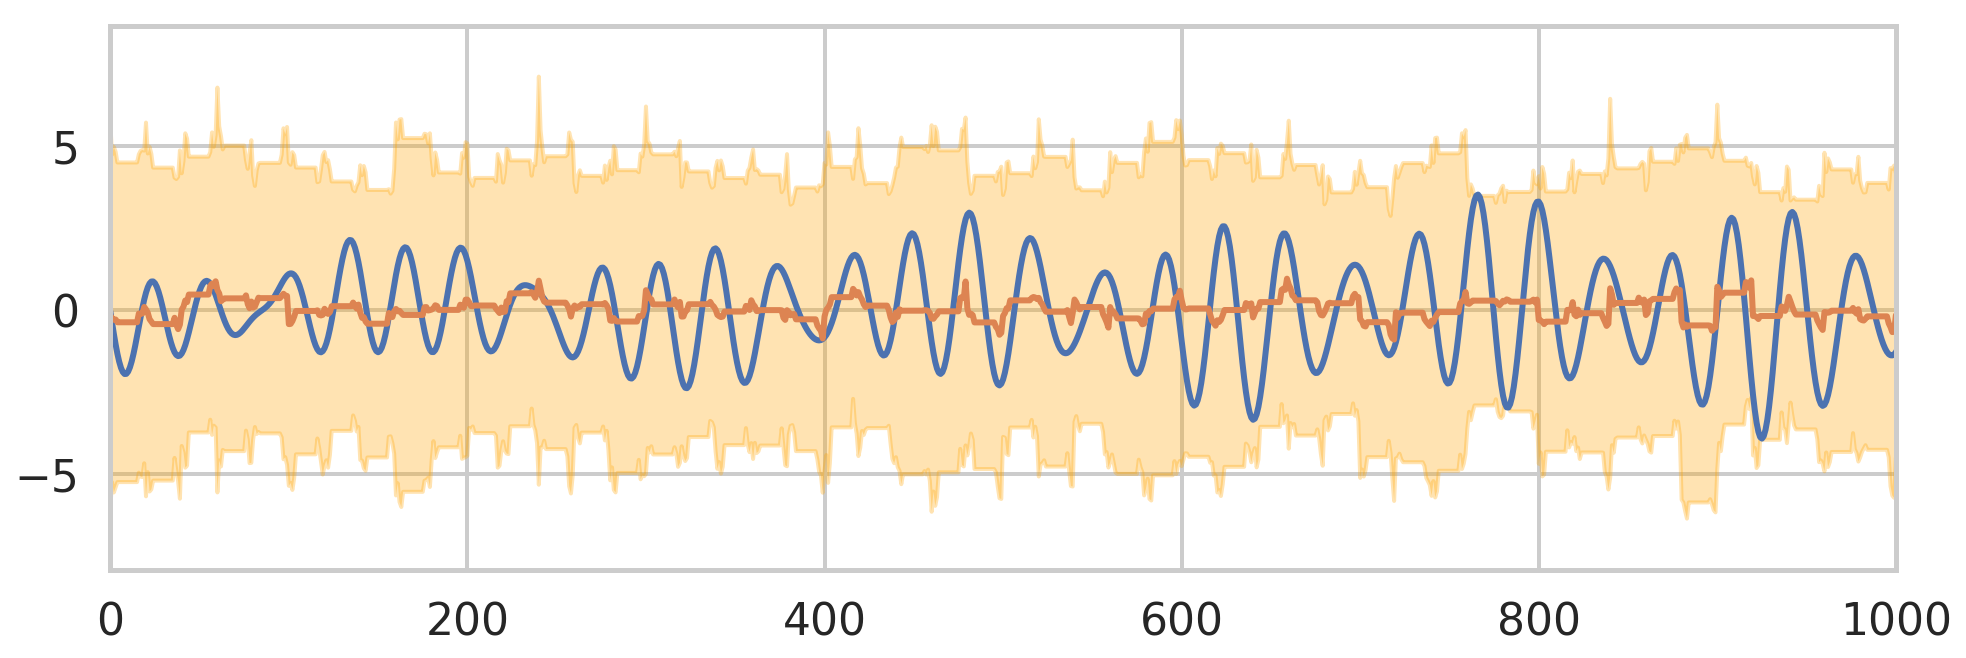

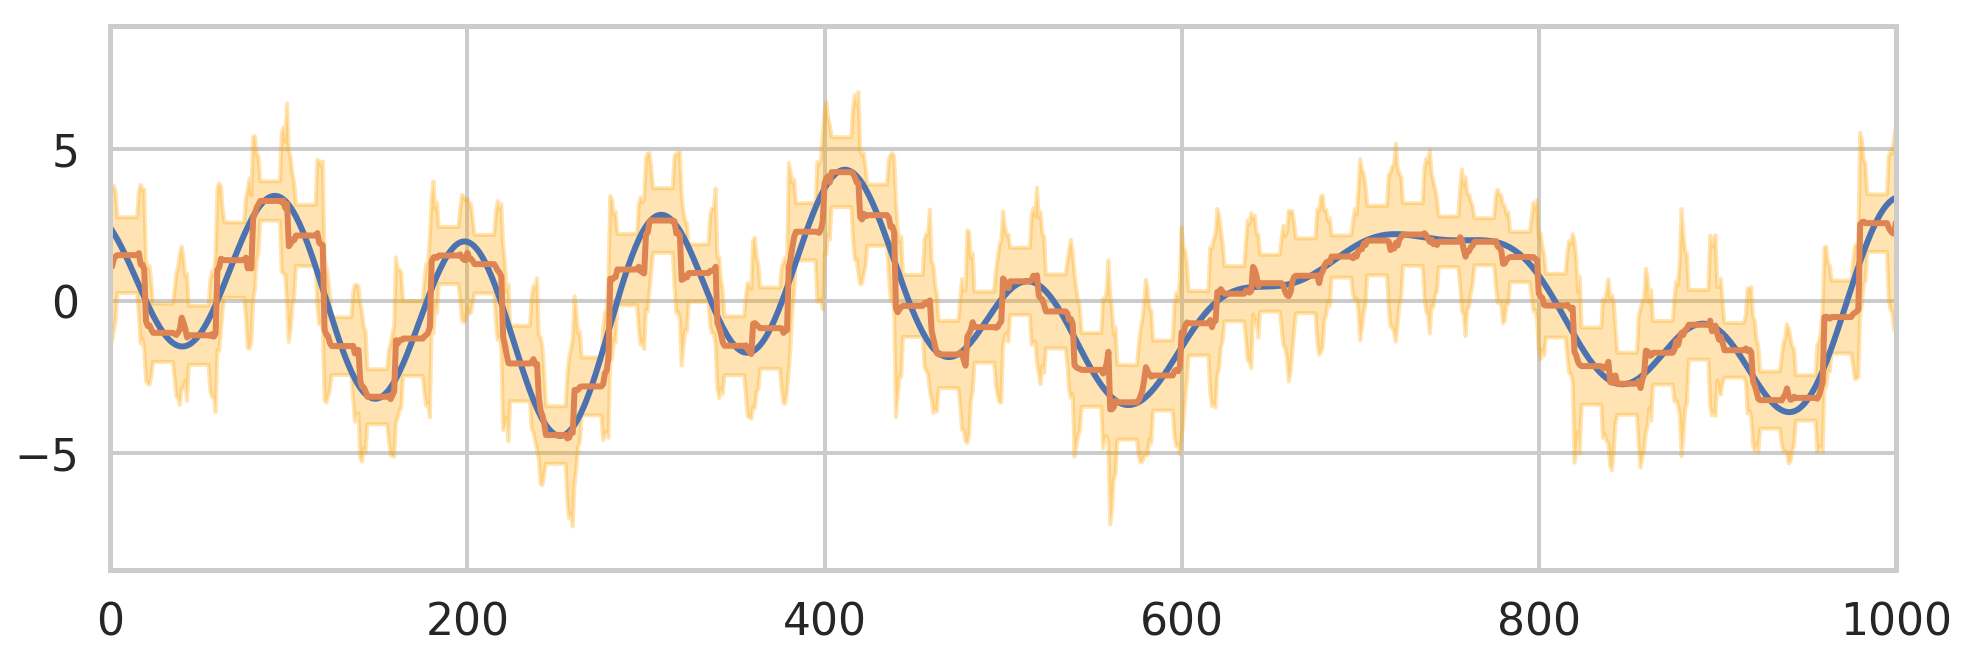

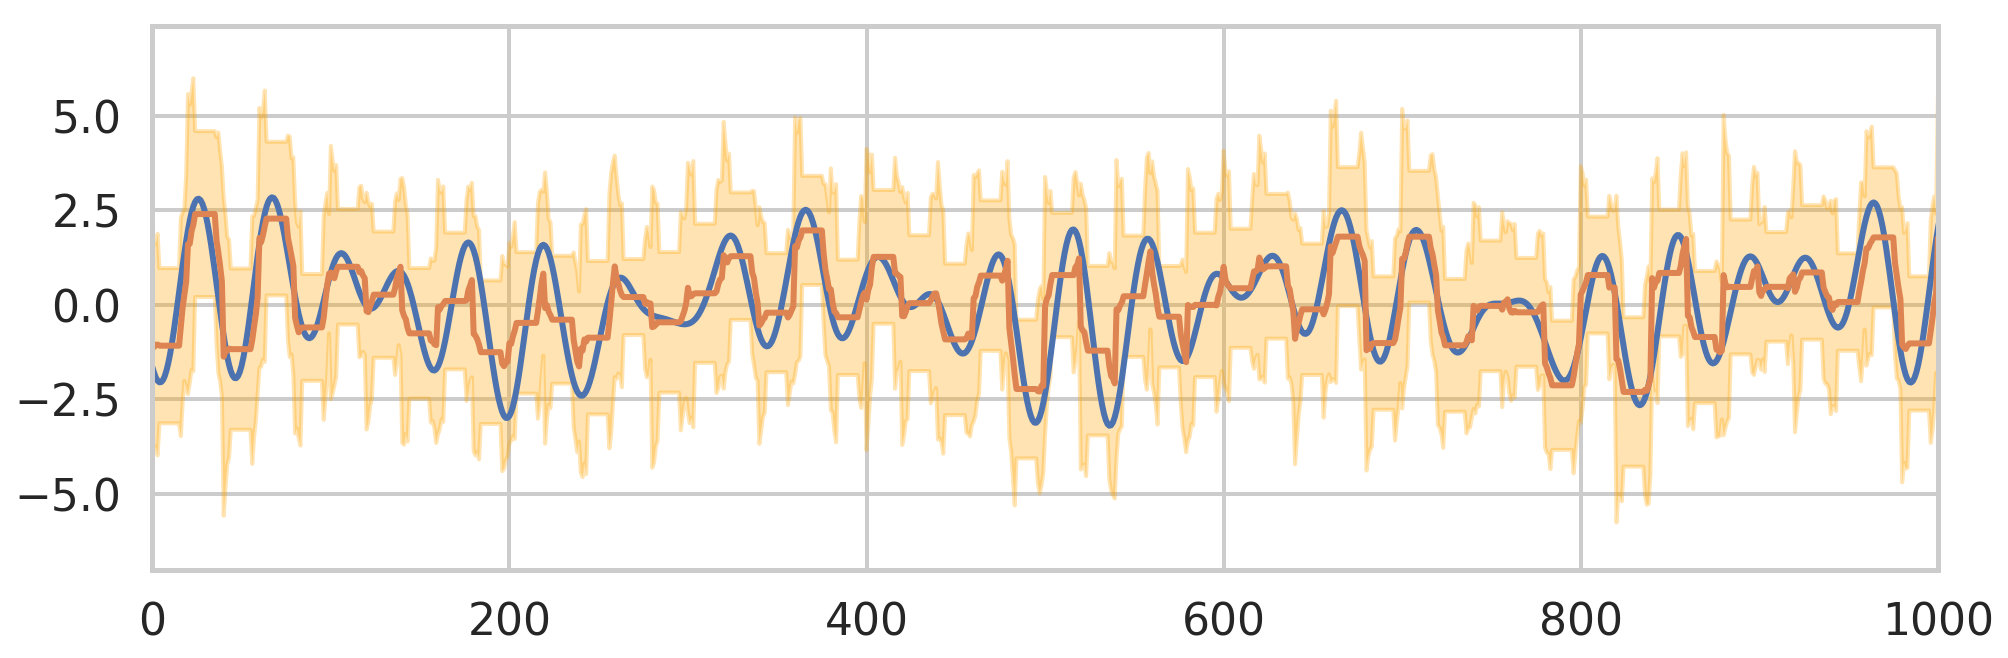

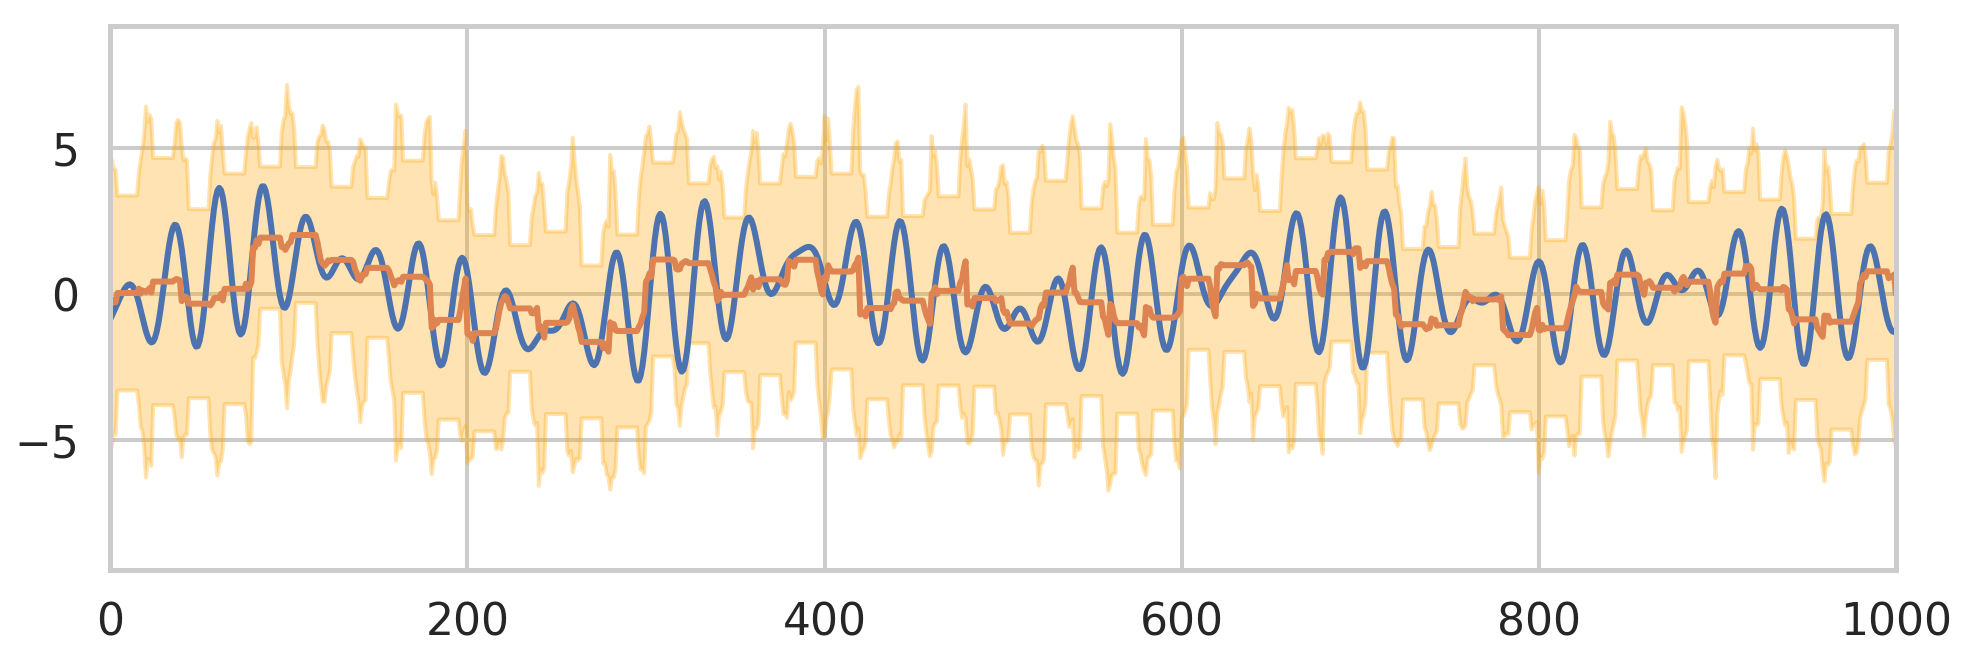

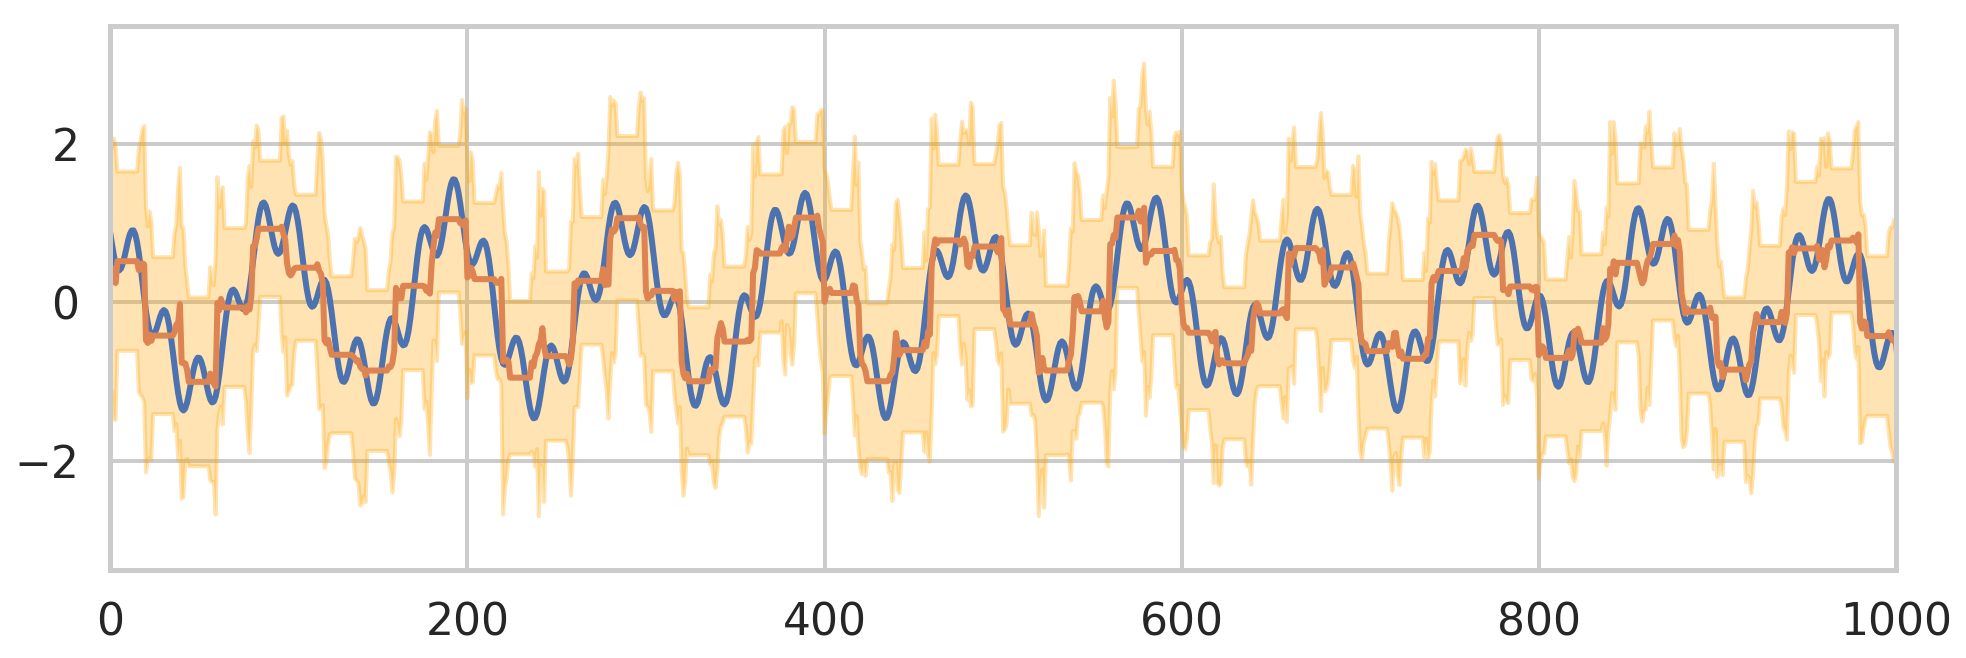

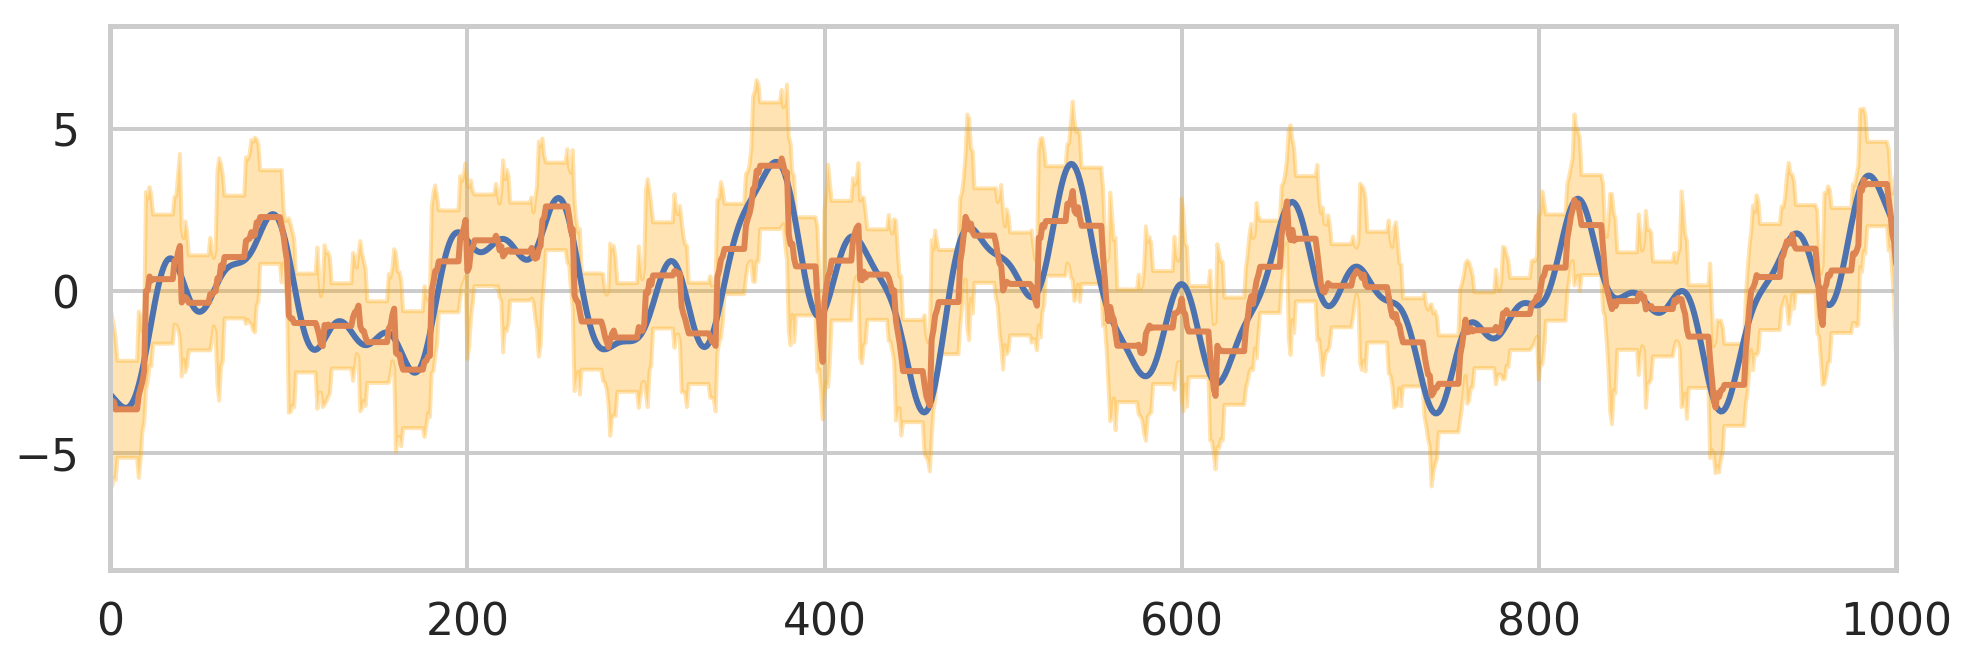

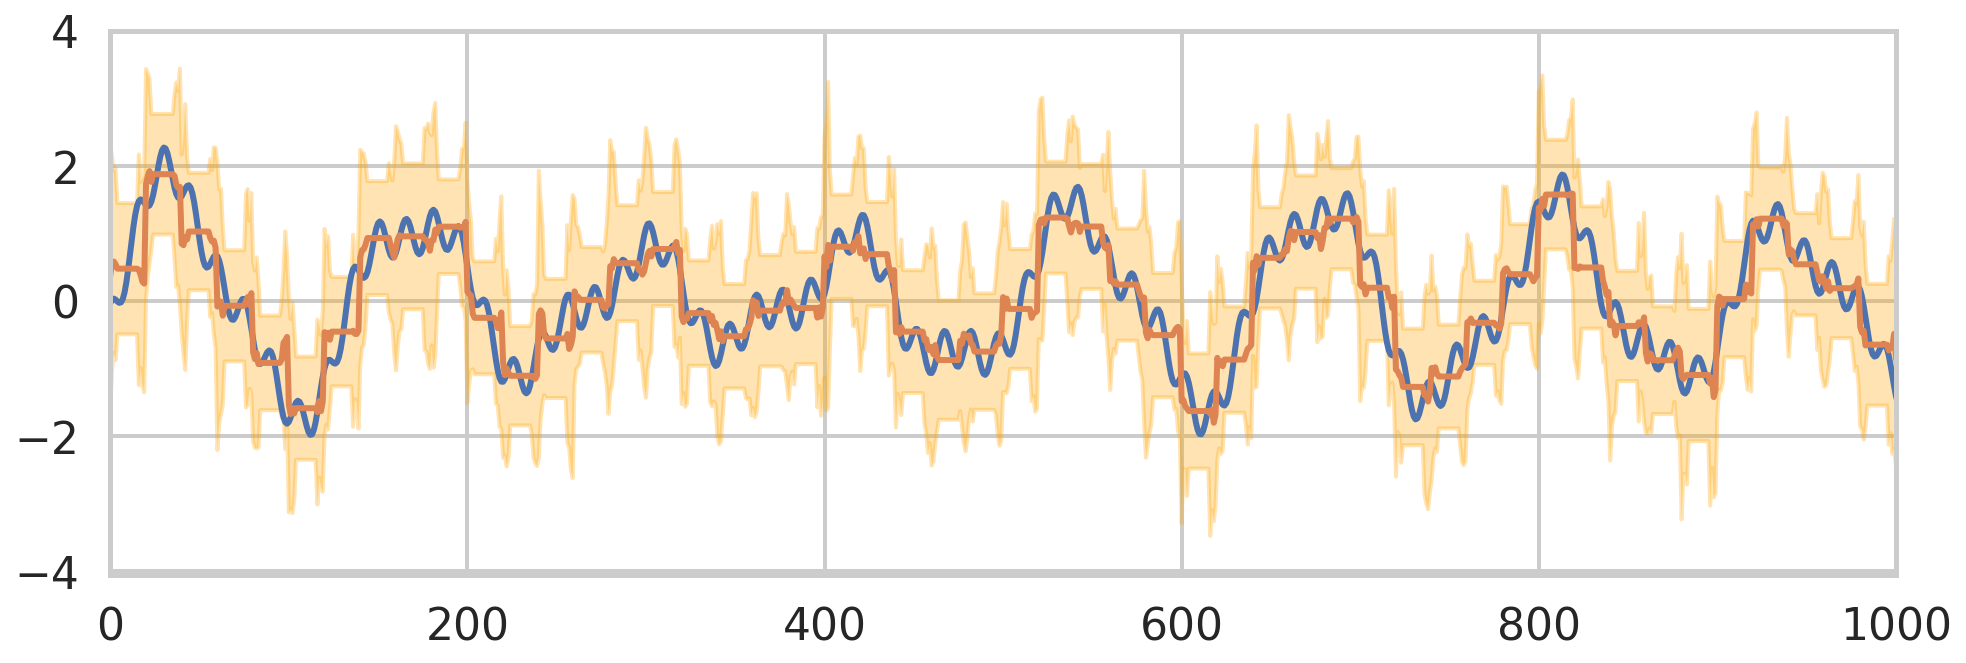

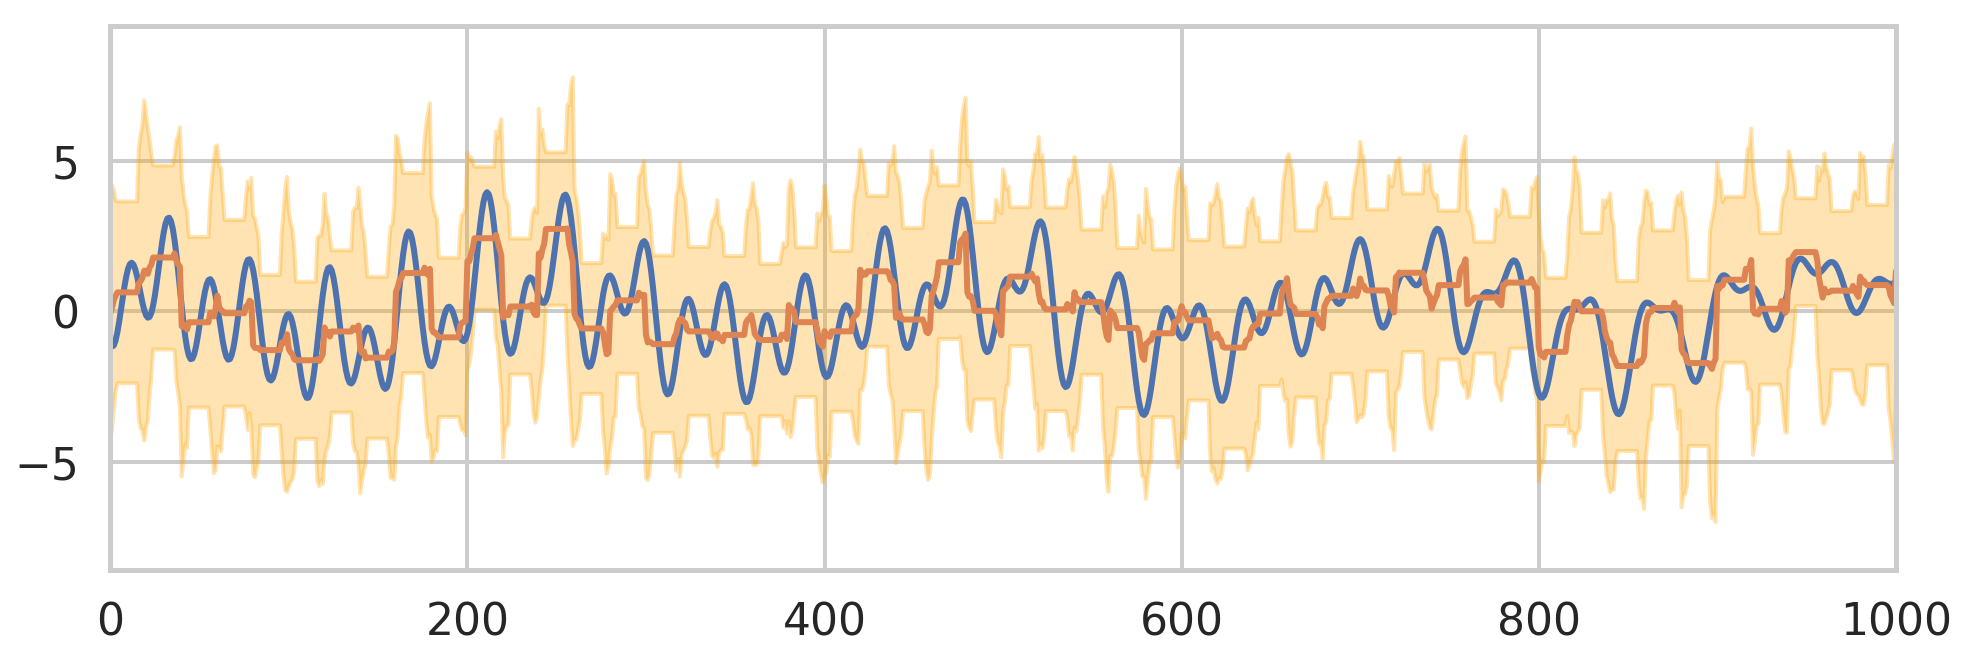

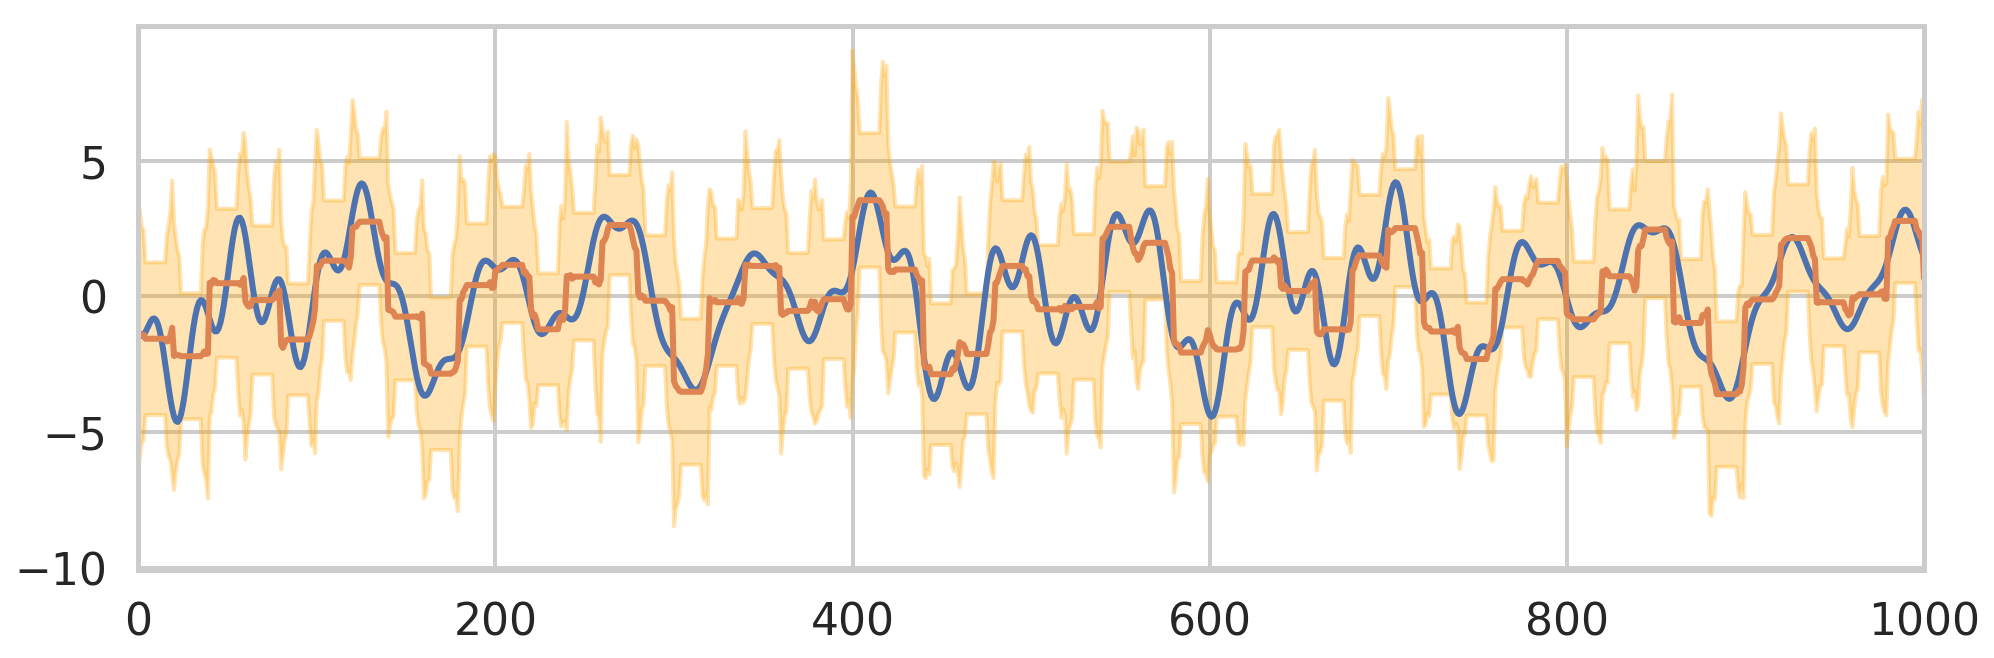

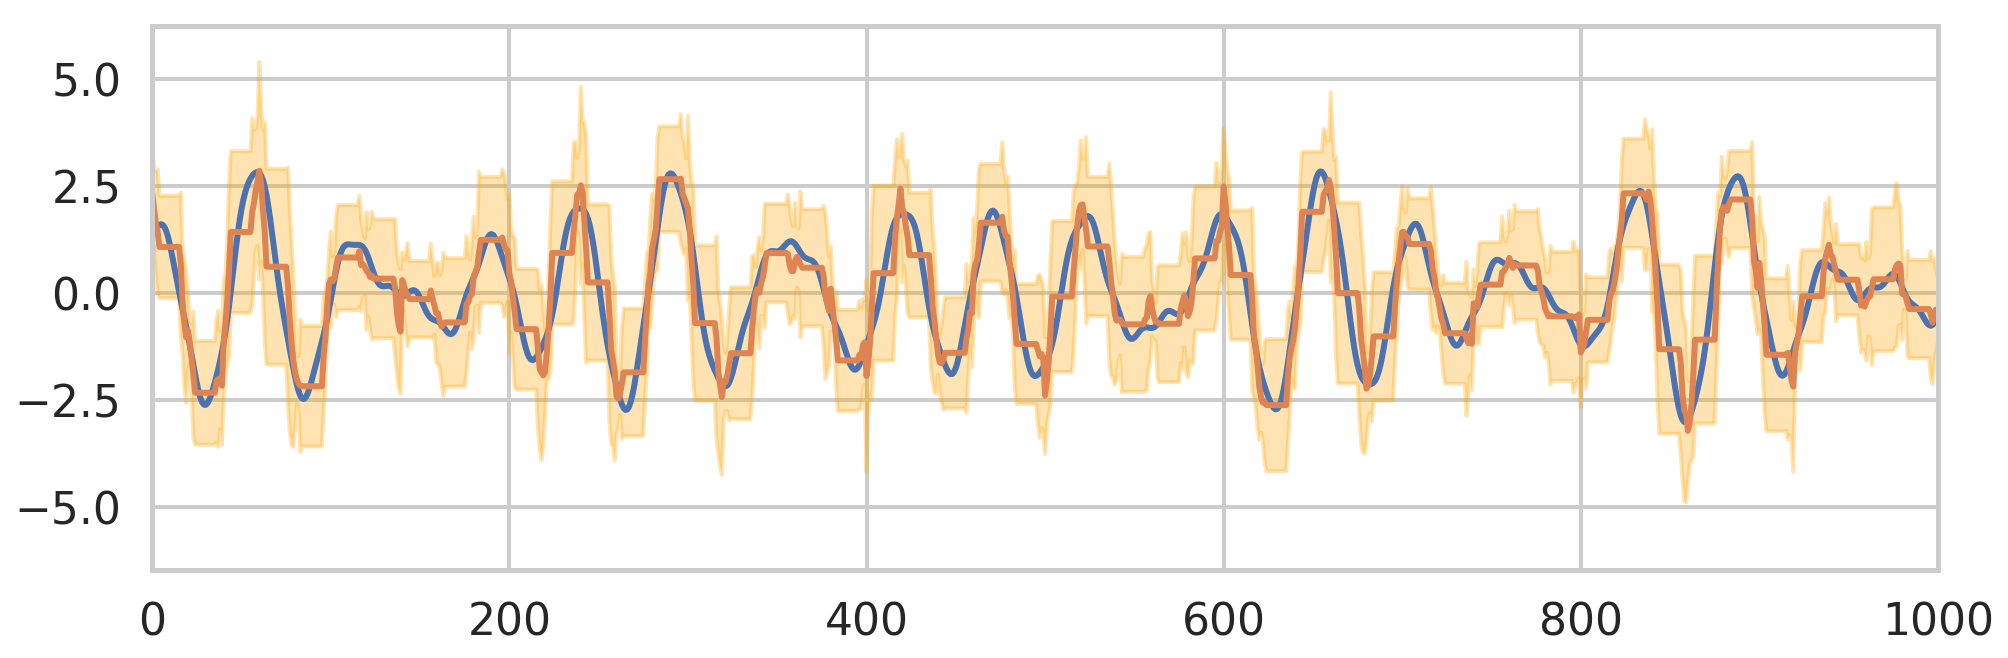

In [35]:
means, stds = model.predict(data_infer)
means = np.vstack(means)
stds = np.vstack(stds)
xlim = (0, 1000)

for feature_idx in range(NUM_FEATURES):
    plt.figure(figsize=(16, 5))
    plt.plot(data[:, feature_idx])
    plt.plot(means[:, feature_idx])
    
    
    plt.fill_between(
        list(range(len(data))),
        means[:, feature_idx] - 3 * stds[:, feature_idx],
        means[:, feature_idx] + 3 * stds[:, feature_idx],
        color='orange', alpha=0.3)
    plt.xlim(xlim)
    plt.show()